In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pyplot as plt
from numpy import *
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
vals = load(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\Master_list.npy") #Load npy array.
with open(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\Master_ref.txt",'r') as myfile: #Print txt file.
    data=myfile.read()
    print([i.strip().split() for i in data.split(' \\n') if len(i.strip())>0])

[['Si', 'SiO2', 'Al', 'GaAs', 'Ge', 'In4Sn3O12', 'Cu', 'ZnO', 'LiNbO3', 'KTiOPO4', 'SiC', 'SiO2C', 'AlC', 'GaAsC', 'GeC', 'In4Sn3O12C', 'CuC', 'ZnOC', 'LiNbO3C', 'KTiOPO4C', 'Thickness', 'Range', '=', '10-10nm', 'Array', 'dimensions', '=', '(20,', '1,', '2048,', '2)']]


In [3]:
with open(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\Mat_list.txt",'r') as myfile: #Use txt list for each material. Will help when producing plots.
    data=myfile.read()
    data = [i.strip().split() for i in data.split(' \\n') if len(i.strip())>0]

In [4]:
for i in range(20): #Change range to number of materials.
    print(data[0][i])


Si
SiO2
Al
GaAs
Ge
In4Sn3O12
Cu
ZnO
LiNbO3
KTiOPO4
SiC
SiO2C
AlC
GaAsC
GeC
In4Sn3O12C
CuC
ZnOC
LiNbO3C
KTiOPO4C


In [5]:
data = data[0][:20]

In [6]:
length = array(range(20))
Mat = torch.as_tensor(length,dtype = torch.long) #Classes.
print(Mat)
[data[i] for i in Mat]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])


['Si',
 'SiO2',
 'Al',
 'GaAs',
 'Ge',
 'In4Sn3O12',
 'Cu',
 'ZnO',
 'LiNbO3',
 'KTiOPO4',
 'SiC',
 'SiO2C',
 'AlC',
 'GaAsC',
 'GeC',
 'In4Sn3O12C',
 'CuC',
 'ZnOC',
 'LiNbO3C',
 'KTiOPO4C']

In [7]:
energy = torch.tensor(vals[0,0,:,0],dtype=torch.float) #Energies. This is the same array for all spectra, so use any spectra's x-axis.
train = (torch.tensor(vals[:,0,:,1],dtype=torch.float)*10**7) #All y-axes for spectra. You can normalize this, but here I just multiplied by 10^7
print(shape(train))

torch.Size([20, 2048])


In [8]:
import torch.nn.functional as F
y_new = F.one_hot(Mat).to(dtype=torch.float) #One hot encoding for classes. Read PyTorch docs for further info.


In [9]:
def train_model(x,y,f, n_epochs=500):
    opt = SGD(f.parameters(), lr=10**-2) #Perform stochastic gradient descent.
    L = nn.CrossEntropyLoss() #New cross-entropy loss (classification loss) after SGD.
    # Train model
    losses = []
    for _ in tqdm(range(n_epochs)):
        opt.zero_grad() 
        loss_value = L(f(x), y)
        loss_value.backward() 
        opt.step() 
        losses.append(loss_value.item())
    return f, losses #Output is the trained function and the loss for each step. 

N = 2**8 #Array size. Arbitrary, but powers of 2 tend to be (negligibly) faster for most code. 
class MyNeuralNet(nn.Module): #Neural net in question.
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2048,N) #Input x is [N,2048]. Linear layers are fed to nonlinear activation layers.
        self.Matrix2 = nn.Linear(N,N) #Linear layer fed to activation layer below.
        self.Matrix3 = nn.Linear(N,N)
        self.Matrix4 = nn.Linear(N,N)
        self.Matrix5 = nn.Linear(N,20) #Output is [20,20]. Each [ith,:] value is the "probability" of actual material being that particular material.
        #Nonlinear activations.
        self.R = nn.ReLU()
        self.E = nn.Tanh()
        self.P = nn.Mish()
        self.T = nn.GELU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.P(self.Matrix2(x))
        x = self.E(self.Matrix3(x))
        x = self.T(self.Matrix4(x))
        x = self.Matrix5(x)
        return x.squeeze()
n_epochs = 1000000

x = train
y = y_new
f = MyNeuralNet()
print(shape(f(x)))
f(x)
L(f(x), y)
# Train model
f, losses = train_model(x,y,f, n_epochs)

torch.Size([20, 20])


100%|██████████| 1000000/1000000 [1:23:00<00:00, 200.76it/s]


In [10]:
min(losses)

7.230017217807472e-06

In [11]:
shape(f(x))

torch.Size([20, 20])

In [12]:
#This cell normalizes probabilities so that they add up to one. I THINK this works (and would stake my life on it).
stuff = f(x).detach().numpy()
for i in range(20):
    stuff[i] = stuff[i]/linalg.norm(stuff[i])
print(linalg.norm(stuff[0]))
norm = stuff**2*100 #Multiply by 100 for percents.


1.0


In [13]:
ind = empty([20,3])
for i in range(20): #Find 3 highest probabilities (their respective indexes) for each material.
    ind[i] = (argpartition(norm[i], -3)[-3:])


ind = ind.astype(int)
maxes = empty([20,3])
for i in range(20): #Find maxes associated with indexes.
    maxes[i] = (norm[i,ind[i]])
    
maxes.sort() #Sort maxes in array to refer back in plots.


In [14]:
for i in range (20):
    for j in range(3):
        ind[i,j] = where(norm[i] == maxes[i,j])[0] #Get all the indexes into 1 array.

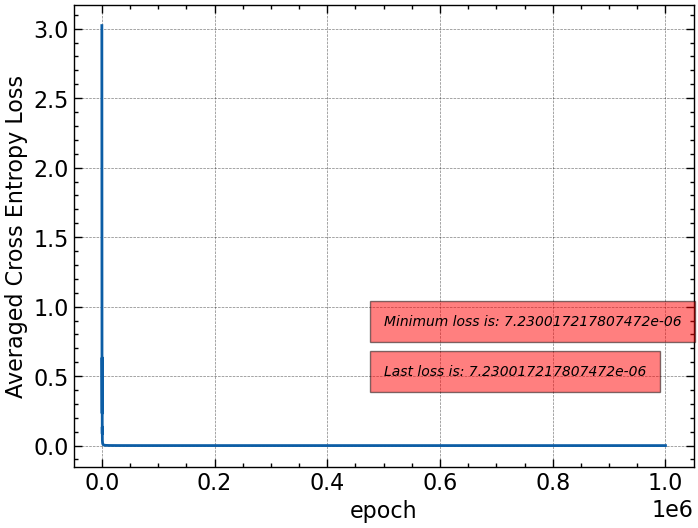

In [18]:
import os
import shutil

path = 'images 2' 
#Optional code to remake output path folder whenever ran:
# if os.path.exists(path):
#     shutil.rmtree(path)
# os.mkdir(path)

#Plot losses, and optionally save.
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("Averaged Cross Entropy Loss")
plt.text(0.5*n_epochs, max(losses)/6, 'Last loss is: {}'.format(losses[-1]), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(0.5*n_epochs, max(losses)/3.5, 'Minimum loss is: {}'.format(min(losses)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.savefig('{}\losses'.format(path), bbox_inches='tight')

plt.show()

In [16]:
torch.save(f, '{}\Material Character.pt'.format(path)) #Save model.

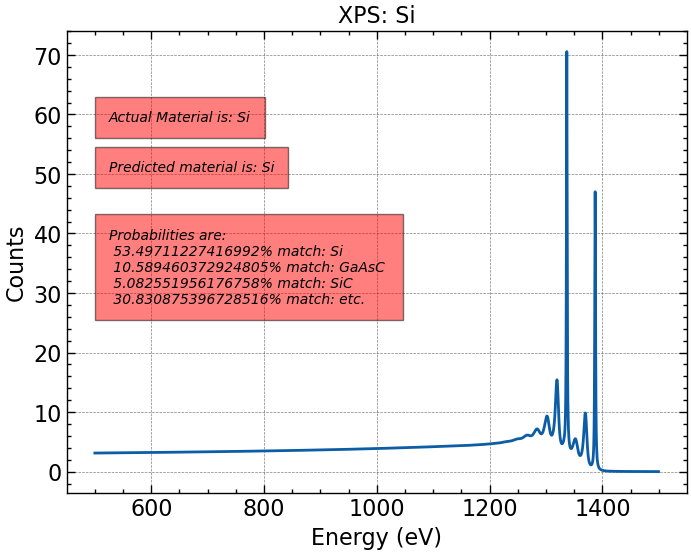

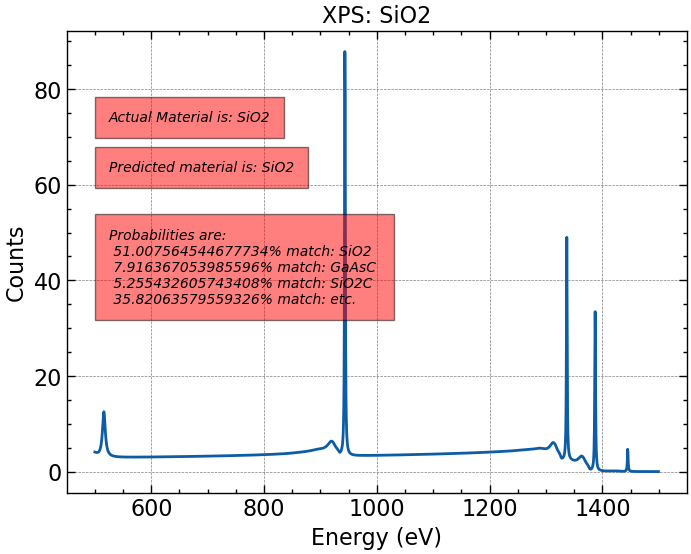

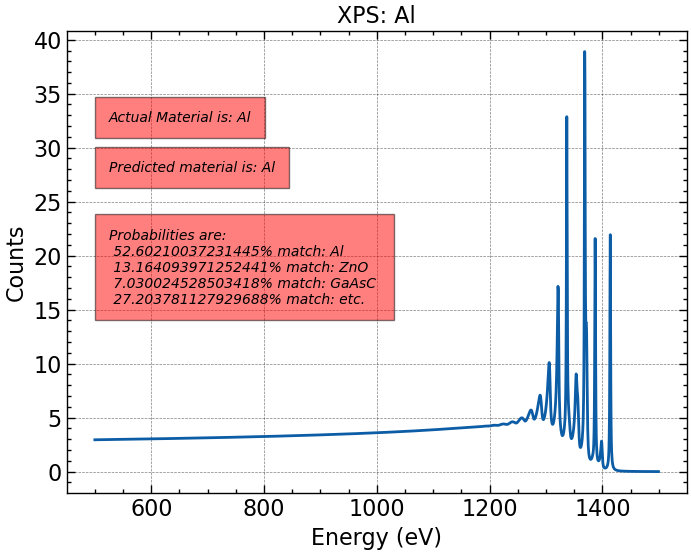

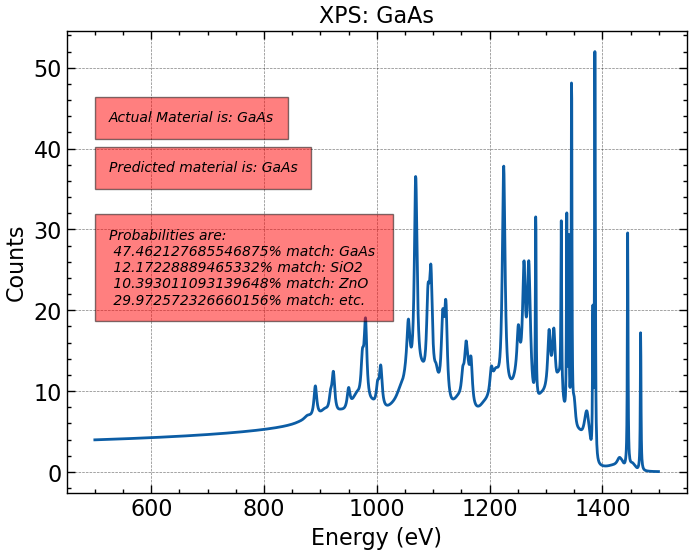

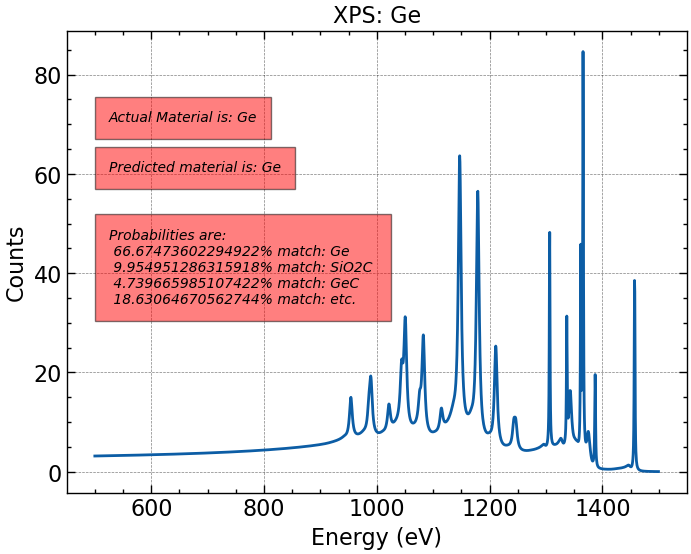

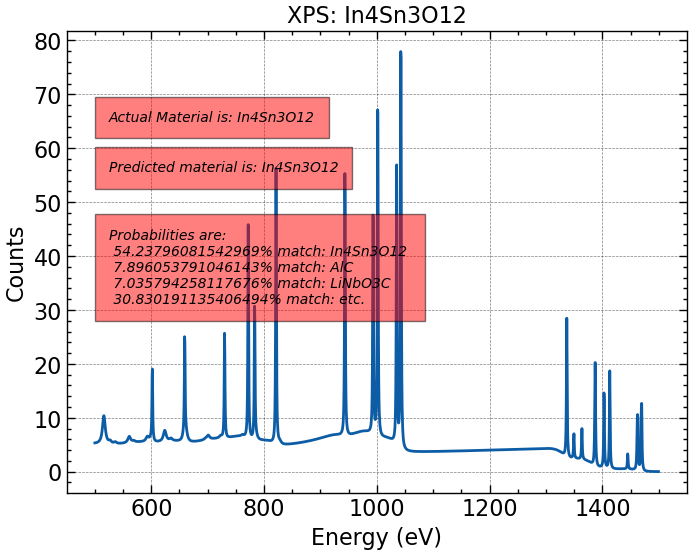

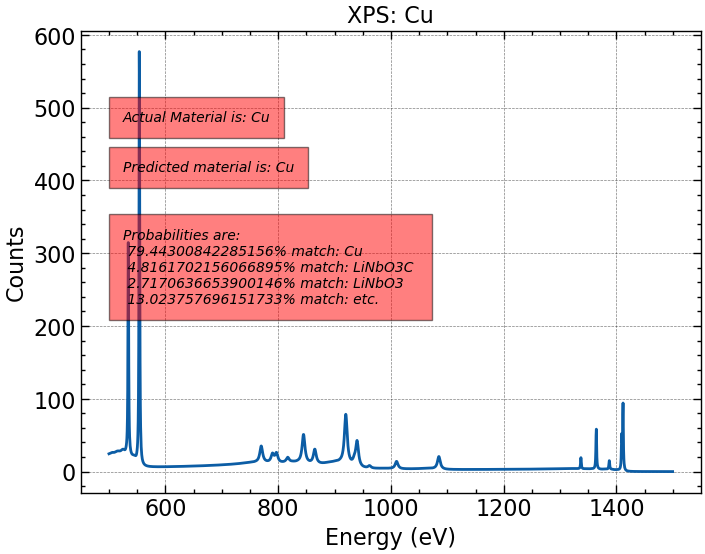

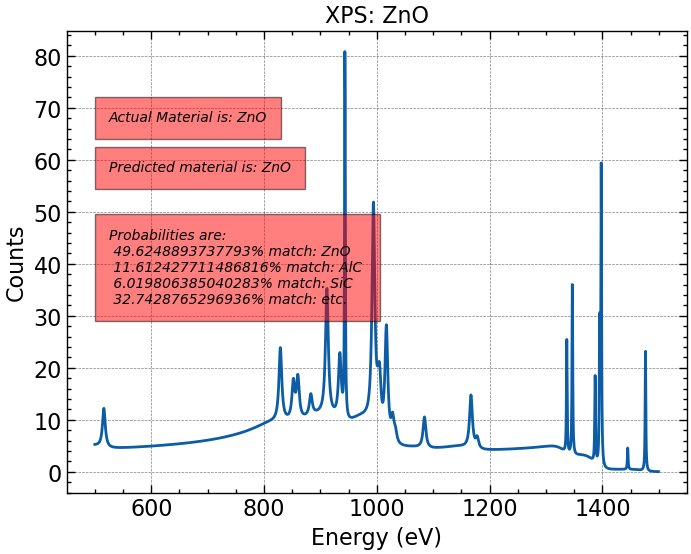

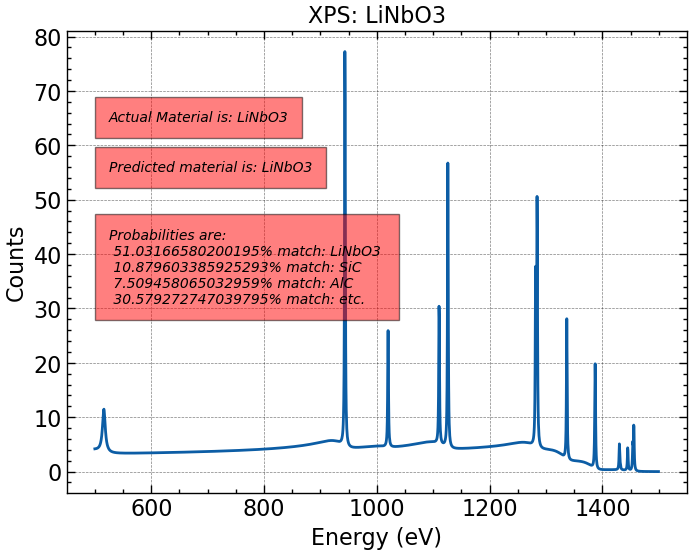

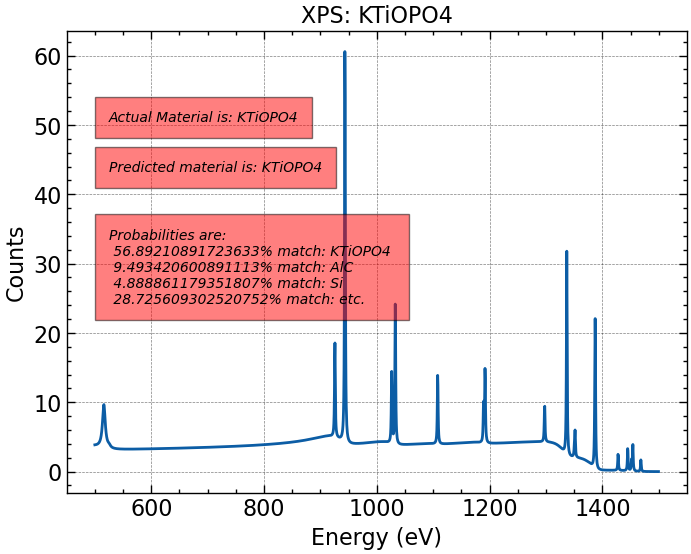

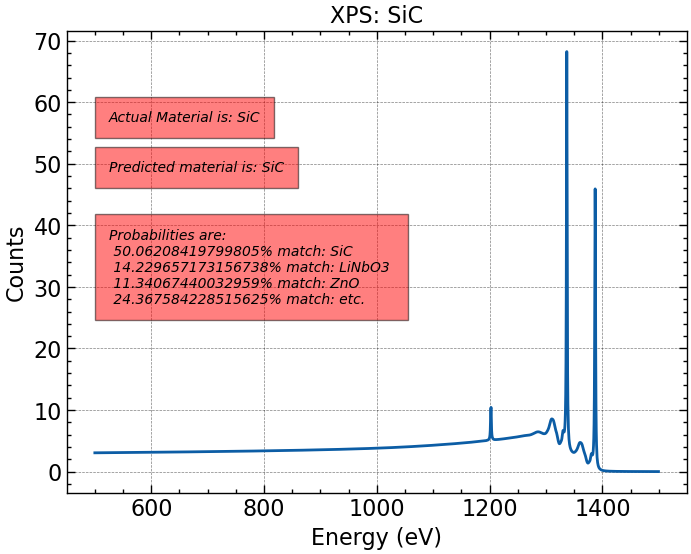

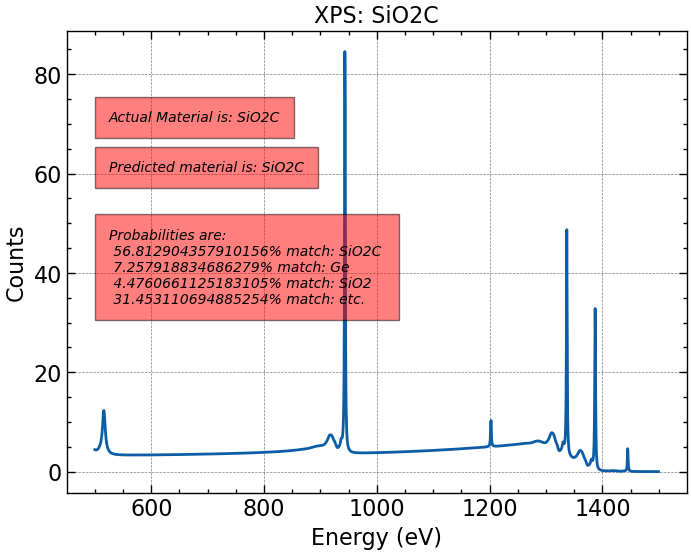

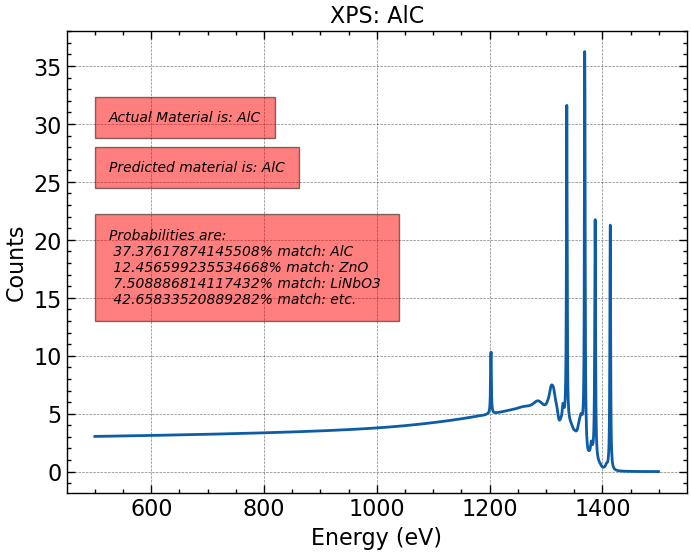

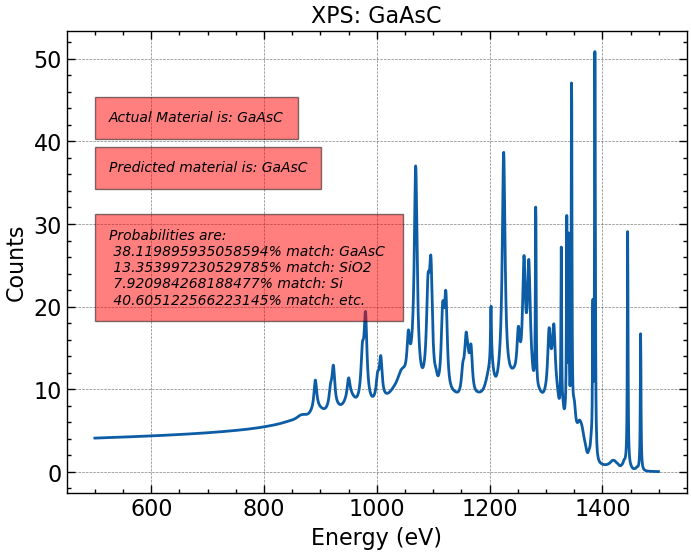

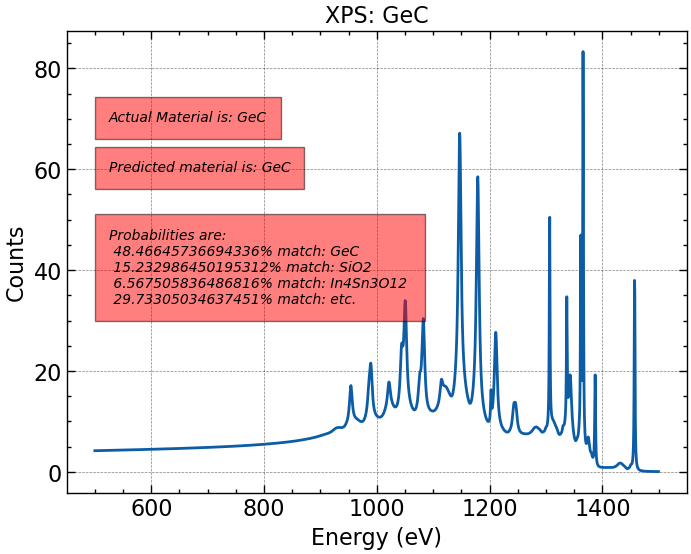

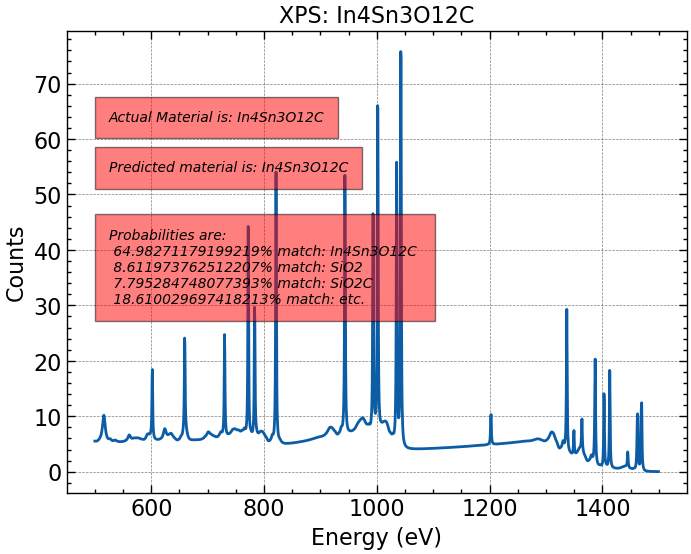

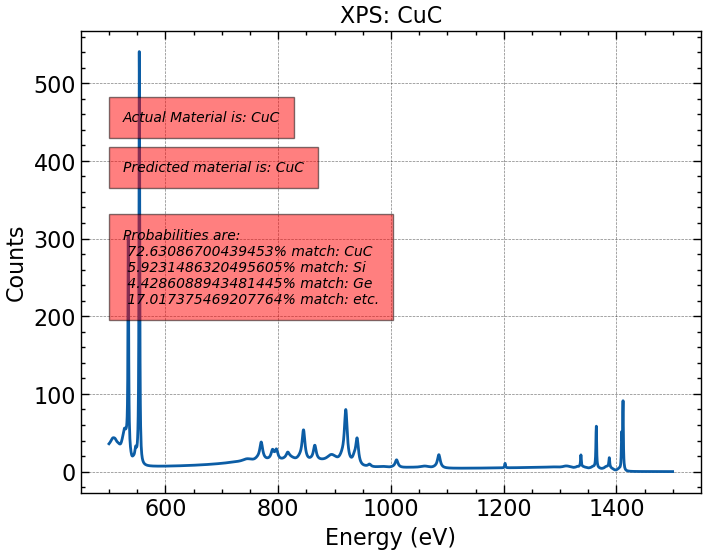

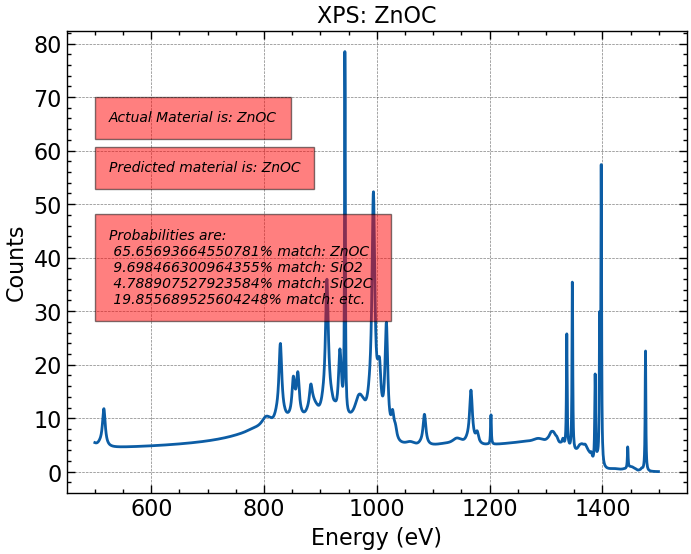

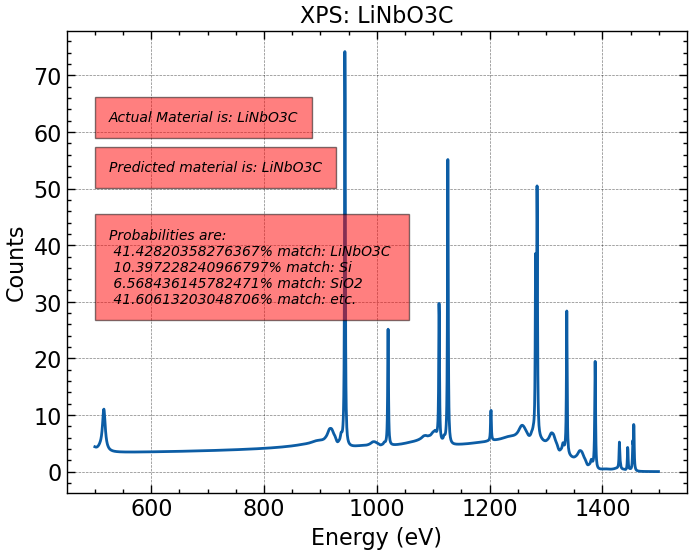

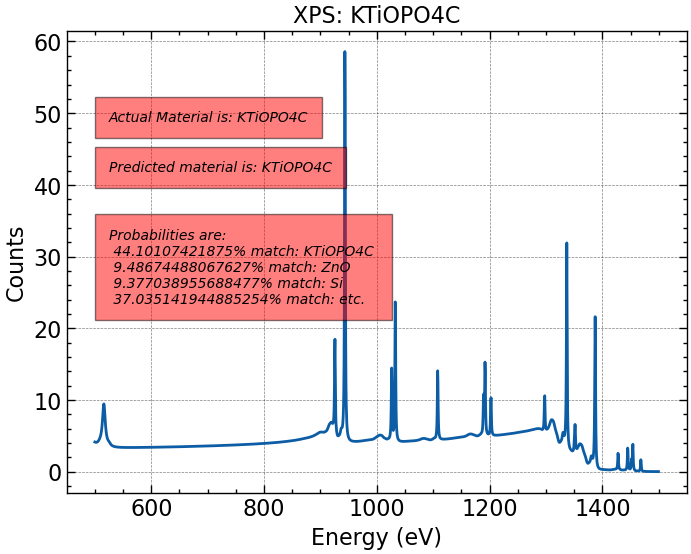

In [19]:
for i in range(20): #Plot each spectra, along with actual material, and top predictions for each material. Very cute!
    plt.plot(energy, train[i])
    values = max(train[i])
    plt.title("XPS: {}".format(data[i]))
    plt.xlabel("Energy (eV)")
    plt.ylabel("Counts")
    plt.text(0.35*max(energy), values/1.2, 'Actual Material is: {}'.format(data[i]), style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.text(0.35*max(energy), values/1.4, 'Predicted material is: {}'.format(data[ind[i,-1]]), style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.text(0.35*max(energy), values/2.5, 'Probabilities are: \n {}% match: {} \n {}% match: {} \n {}% match: {} \n {}% match: etc.'.format(maxes[i,-1],data[ind[i,-1]],maxes[i,-2],data[ind[i,-2]],maxes[i,-3],data[ind[i,-3]],100-sum(maxes[i])), style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.savefig('{}\XPS Predict {}'.format(path,data[i]), bbox_inches='tight')

    plt.show()
    plt.close()